In [1]:
# download from source
# !pip install sktime

# download from fork (because 2 PRs are not merged yet)
# !pip install git+https://github.com/geetu040/sktime.git@gsoc-submission

In [2]:
from sktime.datasets import (
	load_airline,
	load_unit_test,
)
from sktime.utils.plotting import plot_series
from sktime.utils._testing.hierarchical import _make_hierarchical
from sklearn.model_selection import train_test_split

import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"
os.environ["JAX_PLATFORMS"] = "cpu"

import warnings
warnings.filterwarnings("ignore")

# Overview

List of all estimators, I have authored or co-authored

In [3]:
from sktime.registry import all_estimators

all_estimators(
    filter_tags={"authors": "geetu040"},
    return_tags=['capability:global_forecasting', 'ignores-exogeneous-X'],
	return_names=True, as_dataframe=True, suppress_import_stdout=True
)

2024-08-23 21:03:26.945423: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-08-23 21:03:26.945452: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


,name,object,capability:global_forecasting,ignores-exogeneous-X
0,AutoRegressiveWrapper,<class 'sktime.forecasting.compose._autoregres...,True,False
1,DummyGlobalForecaster,<class 'sktime.forecasting.dummy.DummyGlobalFo...,True,False
2,LTSFTransformerForecaster,<class 'sktime.forecasting.ltsf.LTSFTransforme...,None,True
3,MVTSTransformerClassifier,<class 'sktime.classification.deep_learning.mv...,None,None
4,NeuralForecastRNN,<class 'sktime.forecasting.neuralforecast.Neur...,None,False
5,TimesFMForecaster,<class 'sktime.forecasting.timesfm_forecaster....,True,True
6,TinyTimeMixerForecaster,<class 'sktime.forecasting.ttm.TinyTimeMixerFo...,True,True


# AutoRegressiveWrapper

In [4]:
y = load_airline()

In [5]:
from sktime.forecasting.pytorchforecasting import PytorchForecastingNBeats

forecaster = PytorchForecastingNBeats(trainer_params={
    "max_epochs": 20,
})

In [6]:
forecaster.get_tag("requires-fh-in-fit")

True

In [ ]:
%%capture

forecaster.fit(y, fh=list(range(1, 40)))
preds = forecaster.predict()

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

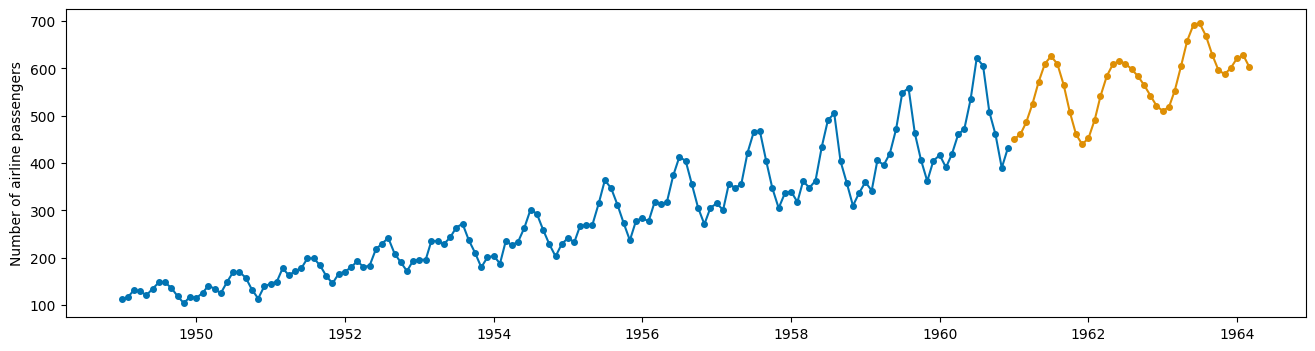

In [8]:
plot_series(y, preds)

In [9]:
# forecaster.predict(fh=[1, 2, 3])
# forecaster.predict(fh=[2, 5])
# forecaster.predict(fh=list(range(1, 50)))

In [10]:
from sktime.forecasting.compose import AutoRegressiveWrapper

forecaster = PytorchForecastingNBeats(trainer_params={
    "max_epochs": 20,
})
wrapper = AutoRegressiveWrapper(forecaster, horizon_length=5)

In [11]:
wrapper.get_tag("requires-fh-in-fit")

False

In [ ]:
%%capture

wrapper.fit(y)
preds = wrapper.predict(fh=list(range(1, 40)))

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

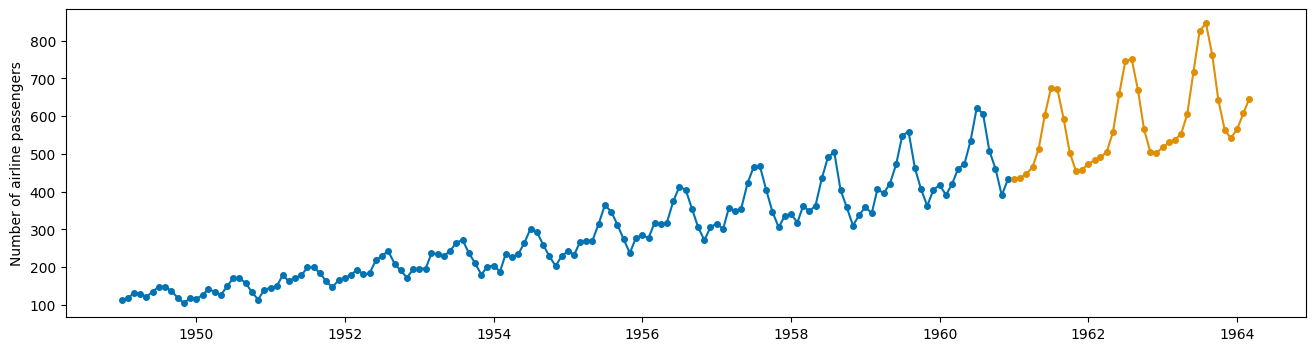

In [13]:
plot_series(y, preds)

In [14]:
forecaster.get_class_tag("capability:global_forecasting")

True

In [15]:
wrapper.get_class_tag("capability:global_forecasting")

True

In [16]:
wrapper.get_class_tag("ignores-exogeneous-X")

False

# LTSFTransformerForecaster

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

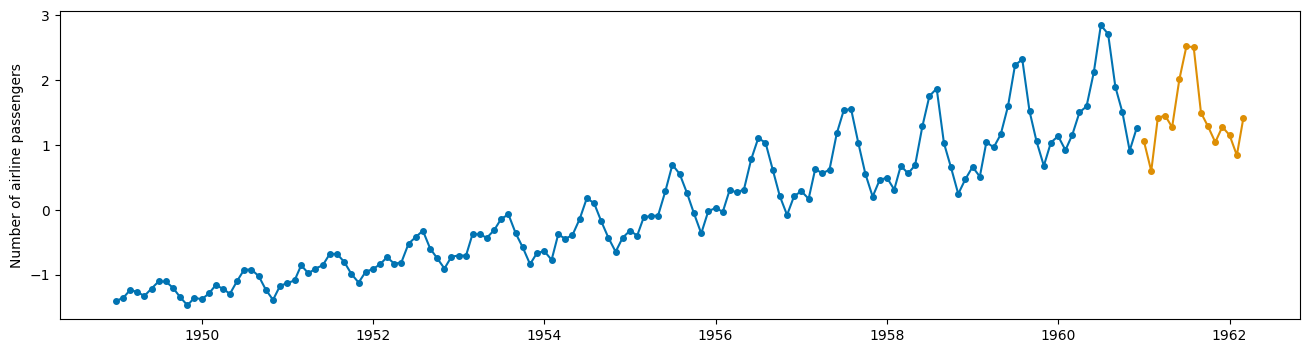

In [17]:
from sktime.forecasting.ltsf import LTSFTransformerForecaster

y = load_airline()

y = (y - y.mean()) / y.std()

model = LTSFTransformerForecaster(
	seq_len=30,
	context_len=15,
	pred_len=15,
    num_epochs=50,
    batch_size=8,
    in_channels=1,
    individual=False,
    criterion=None,
    criterion_kwargs=None,
    optimizer=None,
    optimizer_kwargs=None,
    lr=0.002,
    position_encoding=True,
    temporal_encoding=True,
    temporal_encoding_type="embed",  # linear, embed, fixed-embed
    d_model=32,
    n_heads=1,
    d_ff=64,
    e_layers=1,
    d_layers=1,
    factor=1,
    dropout=0.1,
    activation="relu",
    freq="M",
)

model.fit(y, fh=list(range(1, model.pred_len+1)))

preds = model.predict()
plot_series(y, preds)

In [18]:
model.get_class_tag("ignores-exogeneous-X")

True

# MVTSTransformerClassifier

In [19]:
from sktime.classification.deep_learning import MVTSTransformerClassifier

model = MVTSTransformerClassifier(
    d_model=256,
    n_heads=4,
    num_layers=4,
    dim_feedforward=128,
    dropout=0.1,
    pos_encoding="fixed",
    activation="relu",
    norm="BatchNorm",
    freeze=False,
    num_epochs=10,
	verbose=False,
)

In [20]:
X_train, y_train = load_unit_test(split="train")
X_test, y_test = load_unit_test(split="test")

model.fit(X_train, y_train)
preds = model.predict(X_test)

preds, y_test

(array(['1', '1', '1', '2', '1', '1', '2', '2', '2', '1', '2', '2', '2',
        '2', '2', '2', '2', '2', '2', '2', '2', '1'], dtype='<U1'),
 array(['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '2',
        '2', '2', '2', '2', '2', '2', '2', '2', '2'], dtype='<U1'))

In [21]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, preds)

0.6818181818181818

# TimesFMForecaster

In [22]:
y = load_airline()

In [23]:
from sktime.forecasting.timesfm_forecaster import TimesFMForecaster

forecaster = TimesFMForecaster(
    context_len=64,
    horizon_len=32,
)

In [24]:
%%capture

forecaster.fit(y, fh=list(range(1, forecaster.horizon_len)))
y_pred = forecaster.predict()

ERROR:absl:For checkpoint version > 1.0, we require users to provide
          `train_state_unpadded_shape_dtype_struct` during checkpoint
          saving/restoring, to avoid potential silent bugs when loading
          checkpoints to incompatible unpadded shapes of TrainState.


(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

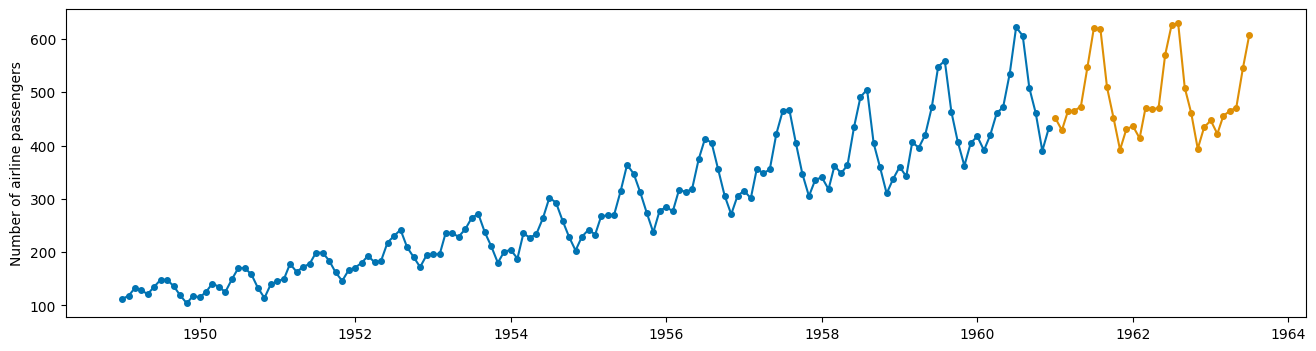

In [25]:
plot_series(y, y_pred)

In [26]:
forecaster.get_class_tag("capability:global_forecasting")

True

In [27]:
y_train

array(['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '2', '2', '2',
       '2', '2', '2', '2', '2', '2', '2'], dtype='<U1')

In [28]:
%%capture

# Preparing the data
y = _make_hierarchical(
    hierarchy_levels=(2, 5), max_timepoints=100, min_timepoints=100, n_columns=1
)
y_train, y_test = train_test_split(
    y, test_size=0.1, shuffle=False
)
y_test = y_test.groupby(level=0).apply(
    lambda x: x.droplevel(0).iloc[:-4]
)

# Loading the model
forecaster = TimesFMForecaster(
    context_len=64,
    horizon_len=32,
)

# fit and forecast
forecaster.fit(y_train, fh=[1, 2, 3, 4])
preds = forecaster.predict(y=y_test)

ERROR:absl:For checkpoint version > 1.0, we require users to provide
          `train_state_unpadded_shape_dtype_struct` during checkpoint
          saving/restoring, to avoid potential silent bugs when loading
          checkpoints to incompatible unpadded shapes of TrainState.


In [29]:
preds

c0
h0   h1   time                
h0_1 h1_4 2000-04-06  3.717694
          2000-04-07  3.780514
          2000-04-08  3.827535
          2000-04-09  3.816883

# TinyTimeMixerForecaster

In [30]:
from sktime.forecasting.ttm import TinyTimeMixerForecaster

y = load_airline()

model = TinyTimeMixerForecaster(
    config={
        "context_length": 20,
        "prediction_length": 10,
    },
    training_args={
        "num_train_epochs": 100,
        "output_dir": "test_output",
        "per_device_train_batch_size": 32,
        "report_to": "none",
        "learning_rate": 1e-2,
    },
)

In [ ]:
%%capture

model.fit(y, fh=list(range(1, 11)))
preds = model.predict()

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

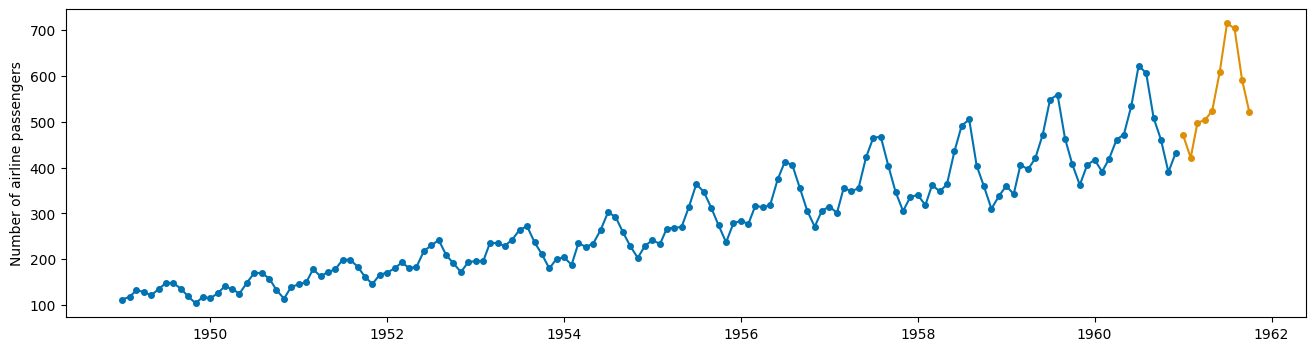

In [32]:
plot_series(y, preds)

In [33]:
forecaster.get_class_tag("capability:global_forecasting")

True

In [ ]:
%%capture

# Preparing the data
y = _make_hierarchical(
    hierarchy_levels=(2, 5), max_timepoints=100, min_timepoints=100, n_columns=2
)
y_train, y_test = train_test_split(
    y, test_size=0.1, shuffle=False
)
y_test = y_test.groupby(level=0).apply(
    lambda x: x.droplevel(0).iloc[:-4]
)

# Loading the model
model = TinyTimeMixerForecaster(
    config={
        "context_length": 20,
        "prediction_length": 10,
    },
    training_args={
        "num_train_epochs": 1,
        "output_dir": "test_output",
        "per_device_train_batch_size": 32,
        "report_to": "none",
        "learning_rate": 1e-2,
    },
	broadcasting=False,
)

# fit and forecast
model.fit(y_train, fh=[1, 2, 3, 4])
preds = model.predict(y=y_test)

In [35]:
preds

c0        c1
h0   h1   time                          
h0_1 h1_4 2000-04-06  4.120028  4.049014
          2000-04-07  4.238961  4.212027
          2000-04-08  4.158207  4.146166
          2000-04-09  4.054813  4.178536